In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2025-05-30 20:05:15.531051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748635515.737630      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748635515.806061      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import shutil
import random
from tqdm import tqdm

# Original dataset path
original_dataset_dir = '/kaggle/input/tomatoleaf/tomato'

# New base directory to copy the restructured dataset
base_dir = '/kaggle/working/tomato_dataset_split'
os.makedirs(base_dir, exist_ok=True)

# Define target folders
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create folders
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Combine 'train' and 'val' folders from original dataset
combined_data_dir = '/kaggle/working/combined'
os.makedirs(combined_data_dir, exist_ok=True)

# Collect all classes (folders) from original dataset
original_train_path = os.path.join(original_dataset_dir, 'train')
original_val_path = os.path.join(original_dataset_dir, 'val')
classes = os.listdir(original_train_path)

# Copy and combine all images into one temp directory
print("Combining original train and val sets...")
for cls in tqdm(classes):
    os.makedirs(os.path.join(combined_data_dir, cls), exist_ok=True)
    
    # Copy train images
    train_cls_path = os.path.join(original_train_path, cls)
    for img in os.listdir(train_cls_path):
        shutil.copy(os.path.join(train_cls_path, img), os.path.join(combined_data_dir, cls, img))
    
    # Copy val images
    val_cls_path = os.path.join(original_val_path, cls)
    for img in os.listdir(val_cls_path):
        shutil.copy(os.path.join(val_cls_path, img), os.path.join(combined_data_dir, cls, img))

# Shuffle and split the images into train, val, test
print("Splitting into 80% train, 10% val, 10% test...")
for cls in tqdm(classes):
    src = os.path.join(combined_data_dir, cls)
    all_imgs = os.listdir(src)
    random.shuffle(all_imgs)
    
    total = len(all_imgs)
    train_split = int(0.8 * total)
    val_split = int(0.9 * total)
    
    train_imgs = all_imgs[:train_split]
    val_imgs = all_imgs[train_split:val_split]
    test_imgs = all_imgs[val_split:]

    # Create class folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(test_dir, cls, img))

print("✅ Dataset successfully restructured!")


Combining original train and val sets...


100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


Splitting into 80% train, 10% val, 10% test...


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]

✅ Dataset successfully restructured!


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/tomato_dataset_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/tomato_dataset_split/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/tomato_dataset_split/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 8800 images belonging to 10 classes.
Found 1100 images belonging to 10 classes.
Found 1100 images belonging to 10 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    # 1st Conv Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd Conv Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 3rd Conv Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 4th Conv Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 5th Conv Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 6th Conv Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense layers
    Flatten(),
    Dense(64, activation='relu'),  # زي ما اتقال في الشرح
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748635856.624025      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748635856.624752      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 295,914 (1.13 MB)

 Trainable params: 295,914 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748635861.289950     121 service.cc:148] XLA service 0x7a2318109990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748635861.291027     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748635861.291048     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748635861.697796     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/275 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.0955 - loss: 2.3053

I0000 00:00:1748635866.191817     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.2022 - loss: 2.0894 - val_accuracy: 0.5664 - val_loss: 1.2472
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5757 - loss: 1.1642 - val_accuracy: 0.6991 - val_loss: 0.8109
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.7400 - loss: 0.7216 - val_accuracy: 0.7009 - val_loss: 0.8662
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7982 - loss: 0.5761 - val_accuracy: 0.8145 - val_loss: 0.5124
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8397 - loss: 0.4545 - val_accuracy: 0.8418 - val_loss: 0.4624
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3514 - val_accuracy: 0.8500 - val_loss: 0.4112
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8965 - loss: 0.3007 - val_accuracy: 0.8518 - val_loss: 0.4379
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9111 - loss: 0.2448 - val_accurac

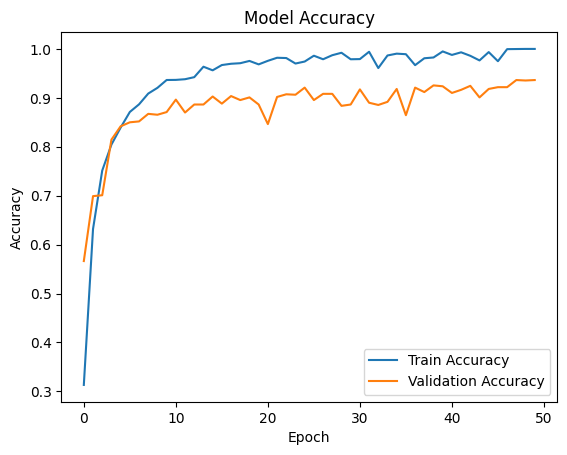

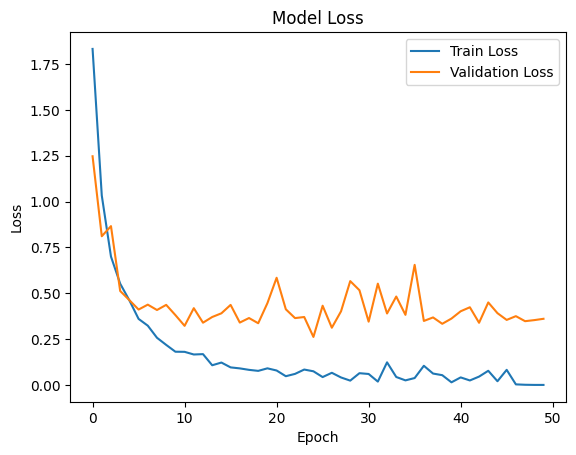

In [5]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9365 - loss: 0.3153
Test Accuracy: 94.27%


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


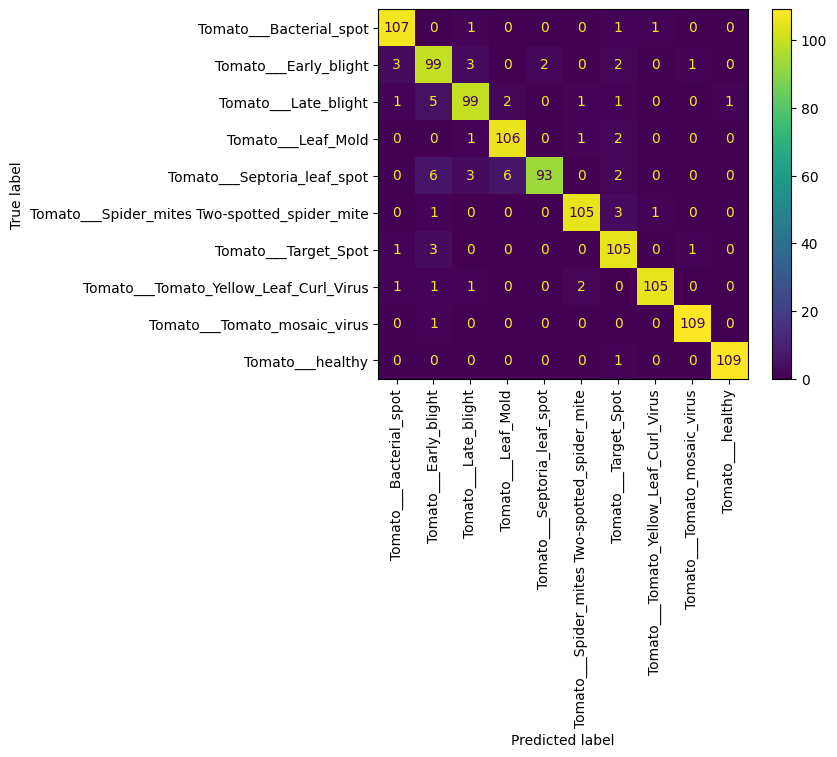

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_generator.class_indices.keys())  # class names

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')
plt.show()


In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=labels))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.95      0.97      0.96       110
                        Tomato___Early_blight       0.85      0.90      0.88       110
                         Tomato___Late_blight       0.92      0.90      0.91       110
                           Tomato___Leaf_Mold       0.93      0.96      0.95       110
                  Tomato___Septoria_leaf_spot       0.98      0.85      0.91       110
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.95      0.96       110
                         Tomato___Target_Spot       0.90      0.95      0.93       110
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.95      0.97       110
                 Tomato___Tomato_mosaic_virus       0.98      0.99      0.99       110
                             Tomato___healthy       0.99      0.99      0.99       110

                                     accu

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom layers
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Build model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=output)

# Compile
model_vgg16.compile(optimizer=Adam(),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

# Train
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 54s 187ms/step - accuracy: 0.2637 - loss: 2.1294 - val_accuracy: 0.6082 - val_loss: 1.4334
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.5406 - loss: 1.4302 - val_accuracy: 0.7264 - val_loss: 1.0370
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.6271 - loss: 1.1364 - val_accuracy: 0.7591 - val_loss: 0.8605
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.6870 - loss: 0.9722 - val_accuracy: 0.7700 - val_loss: 0.7725
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.7037 - loss: 0.9047 - val_accuracy: 0.7918 - val_loss: 0.6755
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.7352 - loss: 0.8084 - val_accuracy: 0.7991 - val_loss: 0.6372
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.7407 - loss: 0.7777 - val_accuracy: 0.7982 - val_loss: 0.6107
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - accuracy: 0.7592 - loss: 0

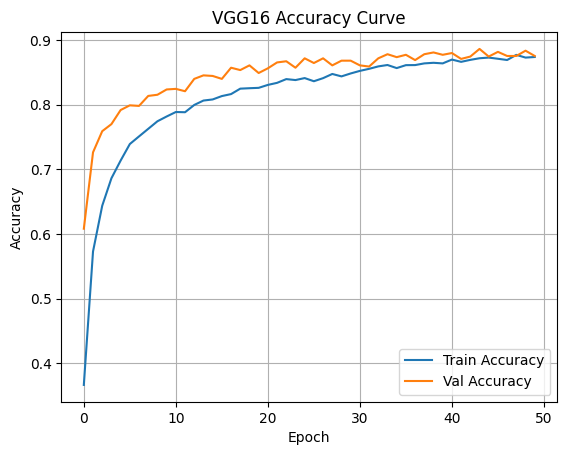

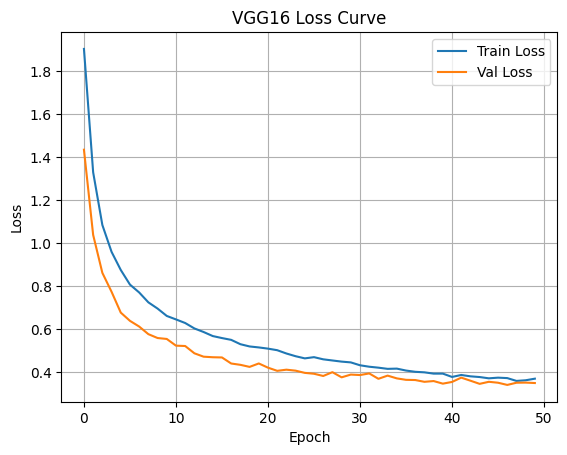

In [19]:
# Accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Val Loss')
plt.title('VGG16 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)
print(f"✅ VGG16 Test Accuracy: {test_accuracy*100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8474 - loss: 0.4866
✅ VGG16 Test Accuracy: 87.45%


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


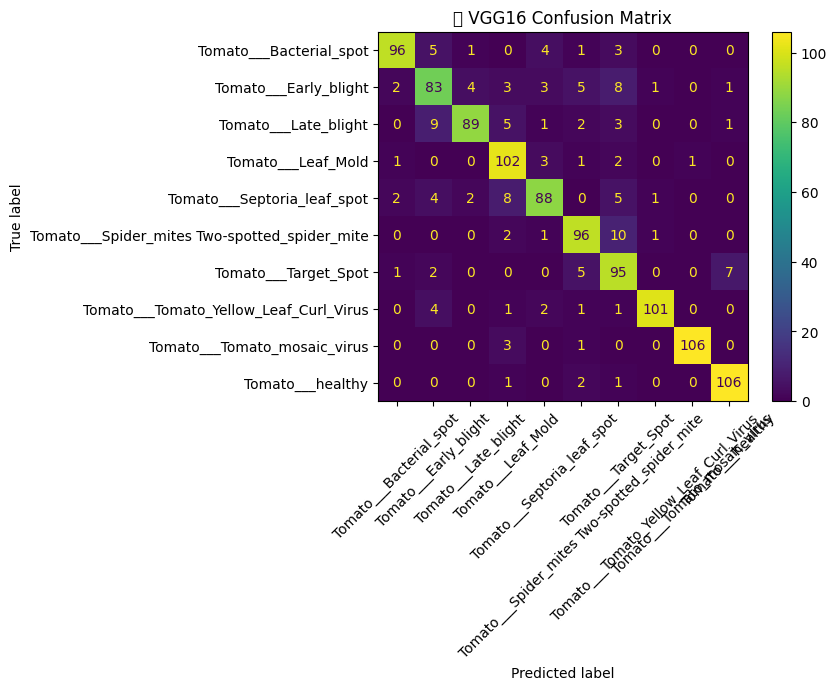

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
Y_pred = model_vgg16.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(xticks_rotation=45)
plt.title("✅ VGG16 Confusion Matrix")
plt.show()


In [20]:
from sklearn.metrics import classification_report

print("✅ VGG16 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


✅ VGG16 Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.87      0.91       110
                        Tomato___Early_blight       0.78      0.75      0.76       110
                         Tomato___Late_blight       0.93      0.81      0.86       110
                           Tomato___Leaf_Mold       0.82      0.93      0.87       110
                  Tomato___Septoria_leaf_spot       0.86      0.80      0.83       110
Tomato___Spider_mites Two-spotted_spider_mite       0.84      0.87      0.86       110
                         Tomato___Target_Spot       0.74      0.86      0.80       110
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.92      0.94       110
                 Tomato___Tomato_mosaic_virus       0.99      0.96      0.98       110
                             Tomato___healthy       0.92      0.96      0.94       110

         

In [21]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model_vgg19.layers:
    layer.trainable = False

# Add custom layers
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Build model
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=output)

# Compile
model_vgg19.compile(optimizer=Adam(),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg19.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,091,338 (76.64 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [22]:
history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 67s 234ms/step - accuracy: 0.2235 - loss: 2.1904 - val_accuracy: 0.5700 - val_loss: 1.5815
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 62s 226ms/step - accuracy: 0.5110 - loss: 1.5447 - val_accuracy: 0.6600 - val_loss: 1.1845
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 62s 227ms/step - accuracy: 0.5727 - loss: 1.2814 - val_accuracy: 0.6909 - val_loss: 1.0040
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 62s 227ms/step - accuracy: 0.6276 - loss: 1.1294 - val_accuracy: 0.7209 - val_loss: 0.9133
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 62s 227ms/step - accuracy: 0.6382 - loss: 1.0779 - val_accuracy: 0.7355 - val_loss: 0.8211
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 63s 227ms/step - accuracy: 0.6768 - loss: 0.9629 - val_accuracy: 0.7418 - val_loss: 0.7886
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 62s 227ms/step - accuracy: 0.6882 - loss: 0.9358 - val_accuracy: 0.7573 - val_loss: 0.7272
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 63s 227ms/step - accuracy: 0.7008 - loss: 0

In [23]:
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f"✅ VGG19 Test Accuracy: {test_accuracy*100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8503 - loss: 0.4468
✅ VGG19 Test Accuracy: 85.73%


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


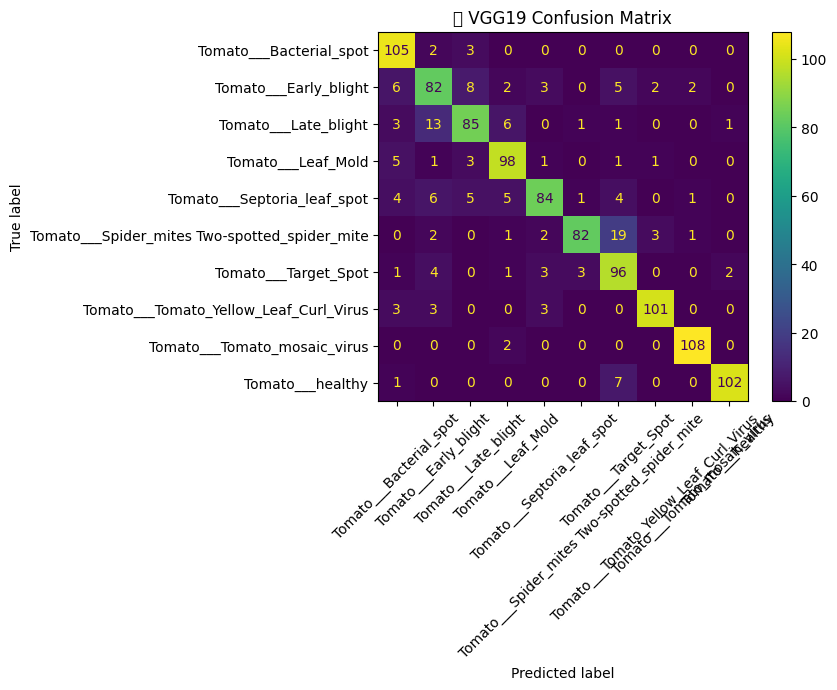

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
Y_pred = model_vgg19.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(xticks_rotation=45)
plt.title("✅ VGG19 Confusion Matrix")
plt.show()


In [25]:
from sklearn.metrics import classification_report

print("✅ VGG19 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


✅ VGG19 Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.82      0.95      0.88       110
                        Tomato___Early_blight       0.73      0.75      0.74       110
                         Tomato___Late_blight       0.82      0.77      0.79       110
                           Tomato___Leaf_Mold       0.85      0.89      0.87       110
                  Tomato___Septoria_leaf_spot       0.88      0.76      0.82       110
Tomato___Spider_mites Two-spotted_spider_mite       0.94      0.75      0.83       110
                         Tomato___Target_Spot       0.72      0.87      0.79       110
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.94      0.92      0.93       110
                 Tomato___Tomato_mosaic_virus       0.96      0.98      0.97       110
                             Tomato___healthy       0.97      0.93      0.95       110

         

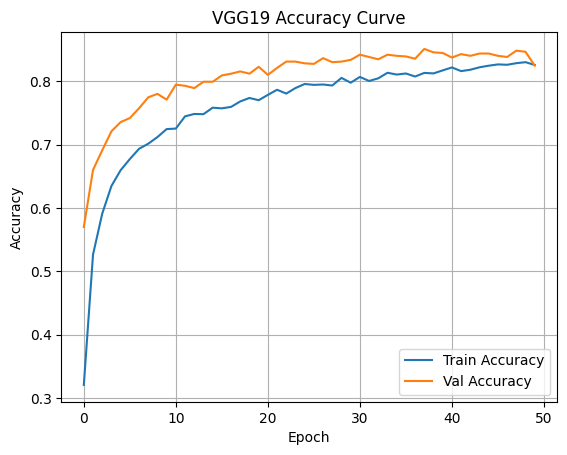

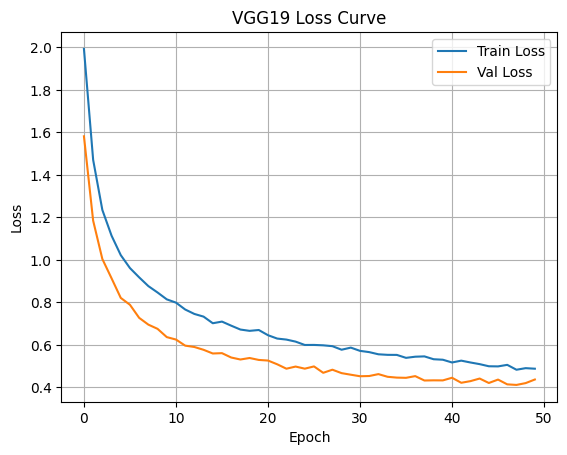

In [26]:
# Accuracy
plt.plot(history_vgg19.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG19 Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg19.history['loss'], label='Train Loss')
plt.plot(history_vgg19.history['val_loss'], label='Val Loss')
plt.title('VGG19 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
